### Predict values based on RNN trained in [RNN_Train_StLaurentDeJourdes](RNN_Train_StLaurentDeJourdes.ipynb) 

---

In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import myFunctions as mf
from myFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [14]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

##### Compute the totalpower  of BT prod and Load on St Laurent 


In [15]:
# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


In [52]:
#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'

# The  commissioning of the Prod P0100 is recent (2022). I therefore use the data of the closer energy 
# producer that is P0058  and consider it as that of Prod P0100 
file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'


# Get files data 
p_mw_0013 = mf.readAndReshape_input(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = mf.readAndReshape_input(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = mf.readAndReshape_input(file_p_inj_0100 ,excel_folder,)



# p_mw_0100_bis = p_mw_0013*upscale_factor
p_mw_prod_bt_total = mf.readAndReshape_input(file_prod_bt_total, excel_folder)
p_mw_cons_total = mf.readAndReshape_input(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])

# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])

# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select only 2020 and 2021 data
df_prodHT = df_prodHT[df_prodHT.index<='2022 06 01 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2022 06 01 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2022 06 01 23:50']


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. Each day total period is therefore given by 10*6
h_start_end = ('07:00','18:50')
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


### Data Cleaning 
See [STLaurentDeJourdes_2](STLaurentDeJourdes_2.ipynb) for a better understanding 

In [54]:
per_index = df_cons_total.index

max_indx = df_cons_total.Cons.argmax()  # Get the indice of the period where the pic occurs
# replace the value with the mean of the previous and following periods
df_cons_total.Cons[max_indx] = (df_cons_total.Cons[max_indx-1] + df_cons_total.Cons[max_indx-1])/2

# Replacing wrong data by the mean of surrounding periods
previous_days = df_cons_total[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_cons_total[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2

# Replacing missing data by the mean of surrondings periods
# Extract previous and following days 
previous_days = df_prodHT.loc[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50'),['P0013','P0018']]
following_days = df_prodHT.loc[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50'),['P0013','P0018']]

# Put the interpolated data into the dataframe
df_prodHT.loc[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50'), ['P0013','P0018']] = (np.array(following_days) + 
                                                                          np.array(previous_days) )/2

In [87]:
# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1)

# Add categorical data
# df_data['Month'] = df_data.index.month
# df_data['hour'] = df_data.index.hour

# # Separate training and testing set 
df_test = df_data[df_data.index>='2021 06 01']


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. Each day total period is therefore given by 10*6
h_start_end = ('06:50','18:50')
per_daylight = ( pd.Series(index=df_test.index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')

df_test=df_test.loc[per_daylight]


### Import trained RNN parameters

In [88]:
import joblib

In [89]:
# Load scaler and RNN from file
scaler = joblib.load('pickle_files/RNN/StLaurent_Final_Scaler.pkl')
lstm_model = tf.keras.models.load_model('pickle_files/RNN/RnnStLaurent_Final')

#### Define history

In [90]:
histTot = df_test.rolling(day_tot_per) # Create a rolling windows to get the history

#### Predict values

In [91]:
hist_list = list(histTot)
len_hist = len(hist_list)
n0  = day_tot_per                 # The first elem 
pred_per, pred = [],[]             
                
for hist_index in tqdm(range(n0, len_hist)):
    cur_hist = hist_list[hist_index]          # current hystory
    
    # run prediction for each period 
    pred_var, pred_per_var = mf.prediction_bloc(rnn_model=lstm_model, 
                                             fitting_scaler=scaler, 
                                             history= cur_hist)
    
    pred_per.append(pred_per_var)
    pred.append(pred_var)
    


100%|██████████| 26646/26646 [37:28<00:00, 11.85it/s]   


#### Define a dataframe of predicted values


In [92]:
predicted_values = pd.DataFrame(np.array(pred).reshape((len(pred),-1)),
                                index=pred_per, 
                                columns = df_test.columns+'_RNN' )

In [95]:
# the prediction periods contains 18PM that need to be removed since the 
# said period is not considered in the test set 
h_start_end = ('07:00', '18:50')
# Redefine prediction periods without 18PM
per_daylight2 = (pd.Series(index=predicted_values.index.to_timestamp(), dtype=object).between_time(*h_start_end)).index.to_period('10T')

# extract the predicted periods based on  per_daylight2
predicted_values = predicted_values.loc[per_daylight2]

# Given that all the values predicted must be positives
# predicted_values [predicted_values<=0] = 0

#### Concatanate real and predicted df

In [105]:
df_final = pd.concat([df_test.iloc[n0+1:,:], predicted_values], axis=1)
df_final = df_final.loc[per_daylight2]

df_final

,Cons,Prod_BT,P0013,P0018,P0100,Cons_RNN,Prod_BT_RNN,P0013_RNN,P0018_RNN,P0100_RNN
2021-06-02 07:00,7.563,0.527,0.020,0.018,0.333,7.688129,0.510646,0.005181,0.002437,0.194658
2021-06-02 07:10,7.451,0.568,0.021,0.020,0.274,7.908918,0.570782,0.026894,0.021193,0.350617
2021-06-02 07:20,7.549,0.671,0.019,0.020,0.254,7.805867,0.636820,0.023820,0.020293,0.285356
2021-06-02 07:30,7.853,0.648,0.028,0.028,0.271,7.846136,0.751392,0.024791,0.023078,0.267684
2021-06-02 07:40,7.713,0.508,0.024,0.026,0.309,8.016215,0.651703,0.026394,0.022836,0.310298
...,...,...,...,...,...,...,...,...,...,...
2022-06-01 18:10,5.478,2.975,0.060,0.073,1.010,6.434535,3.145878,0.067903,0.075982,1.097055
2022-06-01 18:20,5.613,2.820,0.058,0.071,0.959,6.444365,2.618726,0.048881,0.058239,0.878071
2022-06-01 18:30,5.310,2.539,0.047,0.063,0.833,6.506251,2.567080,0.052344,0.060130,0.833873
2022-06-01 18:40,5.184,2.294,0.043,0.053,0.672,6.384345,2.270384,0.043458,0.051514,0.734325


#### Scatter plot prediction and Real values

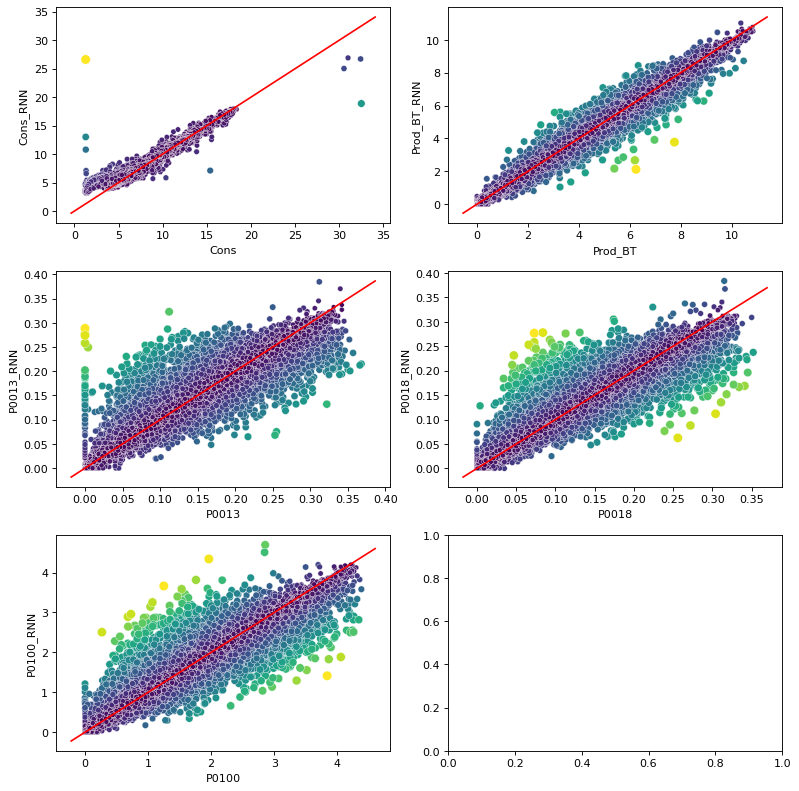

In [106]:
fig, axx = plt.subplots(3,2, figsize=(10,10), dpi=80)

for cur_col, cur_ax in zip(df_test.columns, axx.flatten()):
    ee = abs(df_final[cur_col] - df_final[cur_col+'_RNN']).values
    # sbn.scatterplot(x=cur_col, y=cur_col+'_Pred', data=df_final, ax=cur_ax, hue=ee,size=ee, legend=False,)
    sbn.scatterplot(x=cur_col, y=cur_col+'_RNN', data=df_final, ax=cur_ax, 
                    size=ee, hue=ee, 
                    palette=sbn.color_palette("viridis", as_cmap=True)
                    ,legend=False,)
    
    cur_ax.plot(cur_ax.get_xlim(), cur_ax.get_xlim(),color='red')
    # cur_ax.set(xlim=[0,cur_ax.get_xlim()[1] ], ylim=[0, cur_ax.get_ylim()[1]])
    
fig.tight_layout()

#### Create new dataframe with index covering all periods of all days


In [107]:

# Get year, month and day from the final df
dfirst_year, dfirst_month, dfirst_day = df_final.index[0].year,df_final.index[0].month,df_final.index[0].day
dlast_year, dlast_month, dlast_day = df_final.index[-1].year,df_final.index[-1].month,df_final.index[-1].day

# create first and last period to be used to create new df index
per_first = f'{dfirst_year} {dfirst_month} {dfirst_day}'
per_last = f'{dlast_year} {dlast_month} {dlast_day+1}'
new_per = pd.period_range(start=per_first, end=per_last, freq='10T')

# create new df
new_df = pd.DataFrame(data=0, index=new_per, columns=df_final.columns)

# put the final df inton the new df
new_df.loc[df_final.index] = df_final

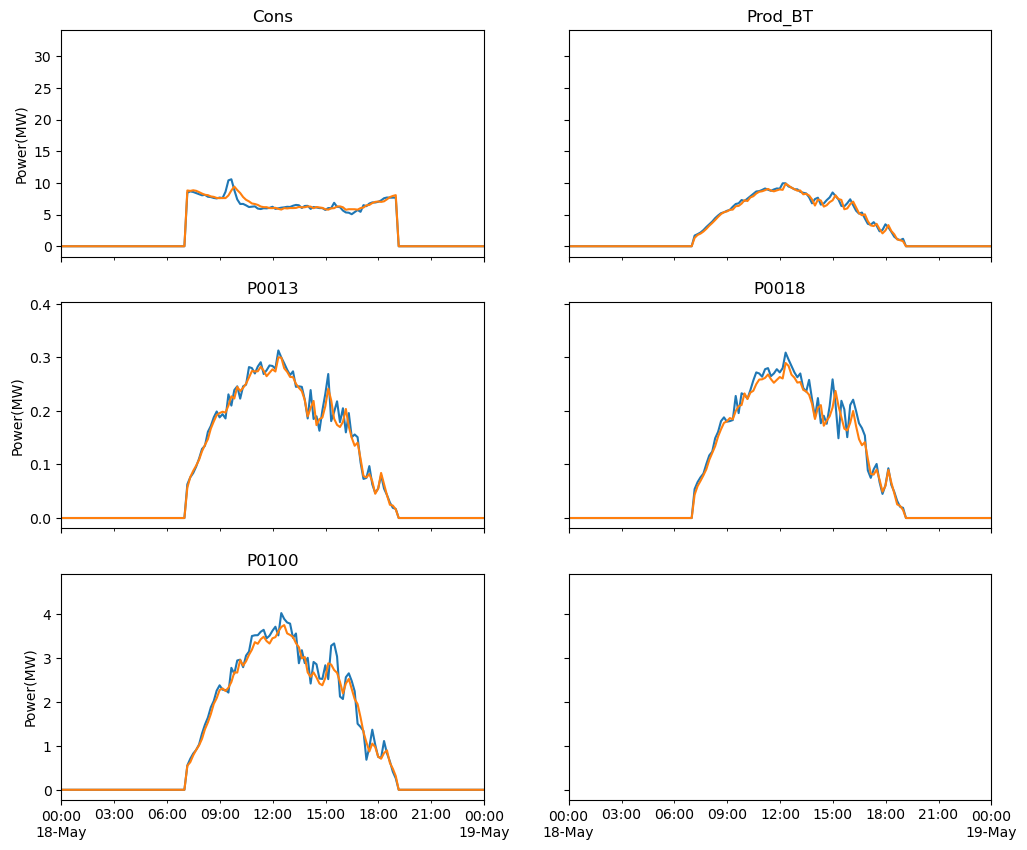

In [108]:
date_lim = ('05 18 2022', '05 19 2022')

fig, axx = plt.subplots(3,2, figsize=(12,10), dpi=100, sharex=True, sharey='row')
for cur_col, cur_ax in zip(df_test.columns, axx.flatten()):
    w2plot= [cur_col, cur_col+'_RNN']
    new_df[w2plot].plot(xlim=date_lim,ax=cur_ax, 
                        legend=False, title=cur_col,ylabel='Power(MW)')


# fig.tight_layout()
# fig.legend(['Real', 'Pred'], bbox_to_anchor=(0.85, 0.25), ncol = 2)
# plt.savefig('Figures/im '+date_lim[0]+'.jpg', dpi=120, bbox_inches='tight')

#### <span style='color:red'> Look in [Figures]('Figures/') for images curves or real and predicted variables</span>*

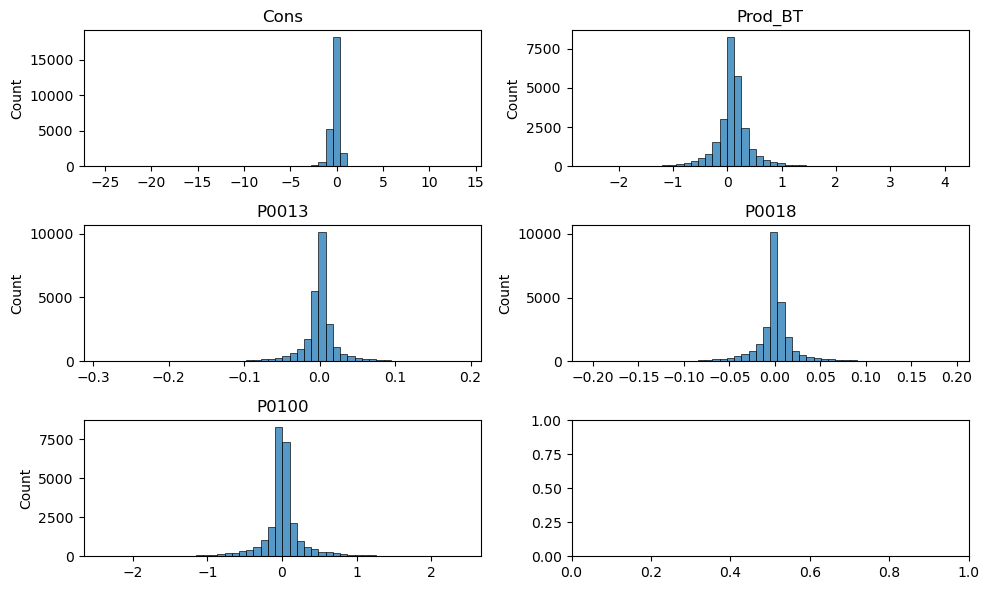

In [109]:
fig, axx = plt.subplots(3,2, figsize=(10,6), dpi=100)

for cur_col, cur_ax in zip(df_test.columns, axx.flatten()):
    ee = (df_final[cur_col] - df_final[cur_col+'_RNN']).values
    # sbn.scatterplot(x=cur_col, y=cur_col+'_Pred', data=df_final, ax=cur_ax, hue=ee,size=ee, legend=False,)
    sbn.histplot(ee, ax=cur_ax, bins=50,  )
    cur_ax.set(title=cur_col)
    
#     cur_ax.plot(cur_ax.get_xlim(), cur_ax.get_xlim(),color='red')
#     cur_ax.set(xlim=[0,cur_ax.get_xlim()[1] ], ylim=[0, cur_ax.get_ylim()[1]])
    
fig.tight_layout()

In [110]:
mean_var = df_test.loc[per_daylight2].mean()
mean_var 

Cons       8.636740
Prod_BT    3.419049
P0013      0.106027
P0018      0.100778
P0100      1.186979
dtype: float64

In [111]:
var =[]
print(f'Prediction Mean absolute Error: ')
for cur_col in df_test:
    val = mean_absolute_error(df_final[cur_col], df_final[cur_col+'_RNN'])
    var.append(val)
    print(f'--- {cur_col:<10}: {val:<1.2} MW')

Prediction Mean absolute Error: 
--- Cons      : 0.35 MW
--- Prod_BT   : 0.24 MW
--- P0013     : 0.015 MW
--- P0018     : 0.014 MW
--- P0100     : 0.17 MW


In [112]:
var2 = np.array(var)*100/mean_var
print(f'Prediction Error percentage : ')
for cur_col in df_test:
    print(f'--- {cur_col:<10}: {var2[cur_col]:<5.2f} %')

Prediction Error percentage : 
--- Cons      : 4.10  %
--- Prod_BT   : 6.95  %
--- P0013     : 13.81 %
--- P0018     : 13.63 %
--- P0100     : 14.06 %


In [114]:
joblib.dump(predicted_values, 'pickle_files/simulationResults/RNN_pred.pkl')


['pickle_files/simulationResults/RNN_pred.pkl']